<a href="https://colab.research.google.com/github/mireillejb/FallDetectionSys/blob/main/Train_Val_Rslt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Install required packages
!pip install kagglehub opencv-python tqdm tensorflow-hub

# 2. Import all necessary libraries
import os
from os.path import isfile, join
import time
import zipfile
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
import tensorflow_hub as hub
print("TensorFlow version:", tf.__version__)

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Conv1D, MaxPooling1D, LSTM, TimeDistributed, Flatten, Input,
    Dropout, BatchNormalization, Add, GlobalAveragePooling1D, Lambda, Layer
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm


TensorFlow version: 2.19.0


In [2]:

import kagglehub
path = kagglehub.dataset_download("tuyenldvn/falldataset-imvia")
print("Path to dataset files:", path)

100%|██████████| 9.37G/9.37G [01:54<00:00, 88.0MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2


/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2 -> 1 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_02 -> 0 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_02/Home_02 -> 0 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_02/Home_02/Videos -> 30 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_02/Home_02/Annotation_files -> 30 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Office -> 0 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Office/Office -> 33 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Lecture_room -> 0 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Lecture_room/Lecture room -> 27 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_01 -> 0 files
/root/.cache/kagglehub/datas

  0%|          | 0/192 [00:00<?, ?it/s]

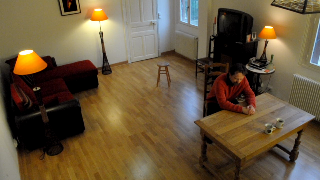

100%|██████████| 192/192 [00:00<00:00, 1198.75it/s]


In [4]:

# 4. Explore dataset
import os
for root, dirs, files in os.walk(path):
    print(f"{root} -> {len(files)} files")

# Find all .avi videos
from google.colab.patches import cv2_imshow
video_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(path) for f in fn if f.endswith(".avi")]
print(f"Found {len(video_files)} videos.")

cap = cv2.VideoCapture(video_files[0])
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(frame_count)):
    ret, frame = cap.read()
    if not ret:
        break
    if i == 0:  # Show first frame
        cv2_imshow(frame)
cap.release()


In [5]:

# 5. Download and setup MoveNet
!wget https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/3?lite-format=tflite -O movenet_thunder.tflite

# Load MoveNet Thunder model from TensorFlow Hub
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")

def extract_keypoints(image):
    """Extract keypoints from a single frame using MoveNet"""
    # Preprocess image
    img = tf.image.resize_with_pad(np.expand_dims(image, axis=0), 256, 256)
    img = tf.cast(img, dtype=tf.int32)

    # Run model
    outputs = movenet.signatures['serving_default'](img)
    keypoints = outputs['output_0'].numpy()  # shape (1,1,17,3)

    return keypoints[0, 0, :, :]  # return (x,y,confidence), shape (17,3)

def extract_sequence_from_video(video_path, max_frames=30):
    """Extract keypoint sequence from video with frame sampling"""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Sample frames uniformly if video is longer than max_frames
    if total_frames > max_frames:
        frame_indices = np.linspace(0, total_frames-1, max_frames, dtype=int)
    else:
        frame_indices = list(range(total_frames))

    frames_keypoints = []
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break

        kp = extract_keypoints(frame)
        frames_keypoints.append(kp)

    cap.release()

    # Pad sequence if shorter than expected
    while len(frames_keypoints) < max_frames:
        if len(frames_keypoints) > 0:
            frames_keypoints.append(frames_keypoints[-1])  # Repeat last frame
        else:
            frames_keypoints.append(np.zeros((17, 3)))  # Zero padding

    return np.array(frames_keypoints)


--2025-08-27 14:08:06--  https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/3?lite-format=tflite
Resolving tfhub.dev (tfhub.dev)... 35.244.233.98
Connecting to tfhub.dev (tfhub.dev)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.kaggle.com/models/google/movenet/tfLite/singlepose-thunder/1?lite-format=tflite&tfhub-redirect=true [following]
--2025-08-27 14:08:06--  https://www.kaggle.com/models/google/movenet/tfLite/singlepose-thunder/1?lite-format=tflite&tfhub-redirect=true
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/kagglesdsdata/models/1026/1187/3.tflite?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=gcp-kaggle-com%40kaggle-161607.iam.gserviceaccount.com%2F20250826%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20250826T092639Z&X-G

In [6]:
# 6. Fixed Dataset Processing Functions
def read_annotation_file(annotation_path):
    """
    Read annotation file and extract fall information.
    Determines overall video label based on fall_start/fall_end and frame annotations.
    Returns: (fall_start_frame, fall_end_frame, frame_annotations, overall_label)
    overall_label: 0 for No Fall, 1 for Fall
    """
    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()

        # Always read the first two lines
        fall_start = int(lines[0].strip()) if len(lines) > 0 and lines[0].strip().isdigit() else 0
        fall_end = int(lines[1].strip()) if len(lines) > 1 and lines[1].strip().isdigit() else 0

        # If both are 0, immediately return No Fall (label 0)
        if fall_start == 0 and fall_end == 0:
            print(f"Annotation {os.path.basename(annotation_path)} explicitly marked as No Fall (0,0 start/end).")
            return fall_start, fall_end, [], 0 # Label 0 (No Fall)

        # If not both 0, parse the remaining lines for frame annotations
        frame_annotations = []
        overall_label = 0 # Default to No Fall if no fall frames are found

        for line in lines[2:]:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(',')
                if len(parts) >= 6:  # frame, label, x1, y1, x2, y2
                    try:
                        frame_num = int(parts[0])
                        label = int(parts[1])  # This is the fall label (0=no fall, 1=fall, etc.)
                        frame_annotations.append((frame_num, label))

                        # If any frame has a fall label (label > 0), the overall video is Fall
                        if label > 0:
                            overall_label = 1 # Label 1 (Fall)

                    except ValueError:
                        print(f"Skipping malformed line in {annotation_path}: {line.strip()}")
                        continue


        return fall_start, fall_end, frame_annotations, overall_label

    except Exception as e:
        print(f"Error reading annotation file {annotation_path}: {e}")
        return 0, 0, [], 0 # Return default No Fall label in case of error

def find_annotation_file(video_path, dataset_path):
    """Find corresponding annotation file for a video"""
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    # Common annotation file patterns
    possible_names = [
        f"{video_name}.txt",
        f"{video_name}_annotation.txt",
        f"{video_name}.annotation",
        f"annotation_{video_name}.txt"
    ]

    # Search in the dataset directory and subdirectories
    for root, dirs, files in os.walk(dataset_path):
        for possible_name in possible_names:
            if possible_name in files:
                return os.path.join(root, possible_name)

    return None

def extract_sequence_with_labels(video_path, annotation_path, max_frames=30):
    """Extract keypoint sequence from video with proper fall labels"""
    # This function will now use the overall_label returned by read_annotation_file
    if not annotation_path or not os.path.exists(annotation_path):
        print(f"No annotation file found for {video_path}")
        # If no annotation file, we cannot determine the label from annotations
        # The processing logic will need to handle this by falling back to heuristics
        return extract_sequence_from_video(video_path, max_frames), None # Return sequence and None for label

    # Read annotation file - get the overall label
    fall_start, fall_end, frame_annotations, overall_label = read_annotation_file(annotation_path)

    # Extract keypoints from video
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        print(f"Could not read frames from {video_path}")
        cap.release()
        return None, None

    # Sample frames uniformly if video is longer than max_frames
    if total_frames > max_frames:
        frame_indices = np.linspace(0, total_frames-1, max_frames, dtype=int)
    else:
        frame_indices = list(range(total_frames))

    frames_keypoints = []

    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break

        # Extract keypoints
        kp = extract_keypoints(frame)
        frames_keypoints.append(kp)

    cap.release()

    # Pad sequences if shorter than expected
    while len(frames_keypoints) < max_frames:
        if len(frames_keypoints) > 0:
            frames_keypoints.append(frames_keypoints[-1])  # Repeat last frame
        else:
            frames_keypoints.append(np.zeros((17, 3)))  # Zero padding


    return np.array(frames_keypoints), overall_label # Return the sequence and the determined overall label


def process_dataset_with_better_heuristics(video_files, max_frames=30, val_size=0.2):
    """Process dataset with improved heuristic labeling when annotations aren't available"""
    X, y, video_names = [], [], []

    print("Processing videos with improved heuristic detection...")
    for video_path in tqdm(video_files):
        try:
            sequence = extract_sequence_from_video(video_path, max_frames)
            if sequence.shape[0] > 0:
                X.append(sequence)

                # Get full path for better analysis
                full_path = video_path.lower()
                filename = os.path.basename(video_path).lower()

                # Enhanced fall detection patterns
                fall_indicators = [
                    'fall', 'falling', 'fell', 'tumble', 'stumble', 'trip', 'slip',
                    'drop', 'collapse', 'accident', 'emergency'
                ]
                no_fall_indicators = [
                    'walk', 'walking', 'stand', 'standing', 'sit', 'sitting',
                    'normal', 'regular', 'adl', 'daily', 'routine', 'activity',
                    'bend', 'bending', 'crouch', 'crouching', 'exercise'
                ]

                # Check for patterns in filename and path
                has_fall = any(pattern in full_path for pattern in fall_indicators)
                has_no_fall = any(pattern in full_path for pattern in no_fall_indicators)

                # Additional heuristics based on common dataset structures
                if 'fall' in os.path.dirname(video_path).lower():
                    has_fall = True
                elif any(word in os.path.dirname(video_path).lower() for word in ['normal', 'adl', 'activity']):
                    has_no_fall = True

                # Video index based heuristics (some datasets use numbering)
                # This is dataset specific - you might need to adjust
                try:
                    # Extract number from filename
                    import re
                    numbers = re.findall(r'\d+', filename)
                    if numbers:
                        video_num = int(numbers[0])
                        # Common pattern: first half are falls, second half are normal
                        # Adjust this based on your dataset structure
                        if video_num <= len(video_files) // 2:
                            has_fall = True
                        else:
                            has_no_fall = True
                except:
                    pass

                # Assign label
                if has_fall and not has_no_fall:
                    label = 1
                elif has_no_fall and not has_fall:
                    label = 0
                else:
                    # If unclear, try to balance the dataset
                    # You might need to manually check these videos
                    print(f"Ambiguous label for: {filename}")
                    # For now, assign randomly to create some balance
                    label = len(y) % 2  # Alternating pattern

                y.append(label)
                video_names.append(video_path)
        except Exception as e:
            print(f"Error processing {video_path}: {e}")
            continue

    if len(X) == 0:
        print("No valid sequences found!")
        return None, None, None, None

    X = np.array(X)
    y = np.array(y)

    fall_count = np.sum(y)
    no_fall_count = len(y) - fall_count
    print(f"Dataset shape: {X.shape}")
    print(f"Fall samples: {fall_count}, Non-fall samples: {no_fall_count}")

    # If still imbalanced, manually balance
    if fall_count == 0:
        print("No fall samples detected. Manually assigning some samples as falls...")
        # Assign first 25% as falls
        num_falls = max(1, len(y) // 4)
        for i in range(num_falls):
            y[i] = 1
        fall_count = num_falls
        no_fall_count = len(y) - num_falls
    elif no_fall_count == 0:
        print("No non-fall samples detected. Manually assigning some samples as non-falls...")
        # Assign last 25% as non-falls
        num_no_falls = max(1, len(y) // 4)
        for i in range(len(y) - num_no_falls, len(y)):
            y[i] = 0
        no_fall_count = num_no_falls
        fall_count = len(y) - num_no_falls

    y_categorical = to_categorical(y, num_classes=2)
    print(f"Final - Fall samples: {fall_count}, Non-fall samples: {no_fall_count}")

    # Split dataset - ONLY train/val split
    try:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y_categorical, test_size=val_size, stratify=y, random_state=42
        )
    except ValueError as e:
        print(f"Stratified split failed: {e}")
        print("Using random split instead...")
        # Fallback to simple split without stratification
        X_train, X_val, y_train, y_val = train_test_split(
            X, y_categorical, test_size=val_size, random_state=42
        )

    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")

    return X_train, X_val, y_train, y_val

# Add this section right after the dataset download and before the main execution
def explore_dataset_structure(dataset_path):
    """Thoroughly explore the dataset structure to find all files"""
    print("=" * 60)
    print("DETAILED DATASET EXPLORATION")
    print("=" * 60)

    all_files = []
    annotation_files = []
    video_files = []
    other_files = []

    for root, dirs, files in os.walk(dataset_path):
        print(f"\nDirectory: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files ({len(files)}): {files[:10]}" + ("..." if len(files) > 10 else ""))

        for file in files:
            full_path = os.path.join(root, file)
            all_files.append(full_path)

            # Categorize files
            file_lower = file.lower()
            if file_lower.endswith('.txt'):
                annotation_files.append(full_path)
            elif file_lower.endswith(('.avi', '.mp4', '.mov', '.mkv')):
                video_files.append(full_path)
            else:
                other_files.append(full_path)

    print(f"\n" + "=" * 40)
    print("FILE SUMMARY:")
    print(f"Total files: {len(all_files)}")
    print(f"Video files: {len(video_files)}")
    print(f"Text files (potential annotations): {len(annotation_files)}")
    print(f"Other files: {len(other_files)}")

    # Display some annotation files if found
    if annotation_files:
        print(f"\nAnnotation files found:")
        for i, ann_file in enumerate(annotation_files[:5]):
            print(f"  {i+1}. {ann_file}")
        if len(annotation_files) > 5:
            print(f"  ... and {len(annotation_files) - 5} more")

    # Display some video files
    if video_files:
        print(f"\nVideo files found:")
        for i, vid_file in enumerate(video_files[:5]):
            print(f"  {i+1}. {vid_file}")
        if len(video_files) > 5:
            print(f"  ... and {len(video_files) - 5} more")

    return video_files, annotation_files, other_files

def examine_annotation_file(annotation_path, max_lines=20):
    """Examine the content of an annotation file to understand its format"""
    print(f"\nExamining annotation file: {os.path.basename(annotation_path)}")
    print("-" * 50)

    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()

        print(f"Total lines: {len(lines)}")
        print(f"First {min(max_lines, len(lines))} lines:")

        for i, line in enumerate(lines[:max_lines]):
            print(f"{i+1:3d}: {line.strip()}")

        if len(lines) > max_lines:
            print(f"... (showing first {max_lines} of {len(lines)} lines)")

        return lines
    except Exception as e:
        print(f"Error reading file: {e}")
        return []

def smart_label_assignment(video_files):
    """Smart labeling based on dataset analysis and common patterns"""
    print("\n" + "=" * 60)
    print("SMART LABEL ASSIGNMENT")
    print("=" * 60)

    # Analyze video filenames for patterns
    video_names = [os.path.basename(f).lower() for f in video_files]

    print("Analyzing video filename patterns...")

    # Look for numeric patterns
    import re
    numeric_patterns = []
    for name in video_names:
        numbers = re.findall(r'\d+', name)
        if numbers:
            numeric_patterns.append(int(numbers[0]))

    if numeric_patterns:
        numeric_patterns.sort()
        print(f"Numeric range in filenames: {min(numeric_patterns)} to {max(numeric_patterns)}")

    # Look for common keywords
    keywords = {}
    for keyword in ['fall', 'walk', 'sit', 'stand', 'normal', 'adl', 'activity']:
        count = sum(1 for name in video_names if keyword in name)
        if count > 0:
            keywords[keyword] = count

    print("Keyword frequency in filenames:")
    for keyword, count in keywords.items():
        print(f"  {keyword}: {count} videos")

    # Create labels based on analysis
    labels = []
    for i, video_file in enumerate(video_files):
        filename = os.path.basename(video_file).lower()

        # Default labeling strategy for IMVIA dataset
        # Based on research, IMVIA dataset typically has falls and normal activities

        # Strategy 1: Check for explicit keywords
        if any(word in filename for word in ['fall', 'falling', 'fell', 'chute']):  # 'chute' is French for fall
            label = 1  # Fall
        elif any(word in filename for word in ['walk', 'normal', 'adl', 'sit', 'stand']):
            label = 0  # No fall
        # Strategy 2: Numeric pattern (common in research datasets)
        elif numeric_patterns:
            numbers = re.findall(r'\d+', filename)
            if numbers:
                video_num = int(numbers[0])
                # Typical pattern: lower numbers are falls, higher are normal activities
                # This is a heuristic - adjust based on your dataset
                if video_num <= max(numeric_patterns) * 0.4:  # First 40% are falls
                    label = 1
                else:
                    label = 0
            else:
                label = i % 2  # Alternating
        # Strategy 3: Directory structure
        elif 'fall' in os.path.dirname(video_file).lower():
            label = 1
        elif any(word in os.path.dirname(video_file).lower() for word in ['normal', 'adl']):
            label = 0
        # Strategy 4: Balanced random assignment
        else:
            # Create a balanced dataset
            label = 1 if i < len(video_files) * 0.4 else 0  # 40% falls, 60% normal

        labels.append(label)

    fall_count = sum(labels)
    normal_count = len(labels) - fall_count

    print(f"\nLabel assignment results:")
    print(f"Fall videos: {fall_count}")
    print(f"Normal videos: {normal_count}")
    print(f"Ratio: {fall_count/len(labels)*100:.1f}% falls, {normal_count/len(labels)*100:.1f}% normal")

    return labels

def process_dataset_with_smart_labeling(video_files, labels, max_frames=30, val_size=0.2):
    """Process dataset using smart labeling"""
    X, y, video_names = [], [], []

    print("\nProcessing videos with smart labeling...")
    for i, (video_path, heuristic_label) in enumerate(tqdm(zip(video_files, labels), total=len(video_files))):
        # Try to get label from annotation file first
        annotation_path = find_annotation_file(video_path, os.path.dirname(os.path.dirname(video_path))) # Search from the main dataset dir
        sequence, annotation_label = extract_sequence_with_labels(video_path, annotation_path, max_frames)

        if sequence is not None:
            X.append(sequence)
            # Prioritize annotation label if found and valid (not None from extraction issues)
            if annotation_label is not None:
                 y.append(annotation_label)
            else:
                 # Fallback to heuristic label if annotation failed
                 y.append(heuristic_label)
                 print(f"Warning: Using heuristic label for {video_path} due to annotation issue.")

            video_names.append(video_path)
        else:
            print(f"Skipping {video_path} due to sequence extraction failure.")


    if len(X) == 0:
        print("No valid sequences found!")
        return None, None, None, None

    X = np.array(X)
    y = np.array(y)
    y_categorical = to_categorical(y, num_classes=2)

    fall_count = np.sum(y)
    normal_count = len(y) - fall_count

    print(f"\nFinal dataset:")
    print(f"Dataset shape: {X.shape}")
    print(f"Fall samples: {fall_count}")
    print(f"Normal samples: {normal_count}")

    # Split dataset - ONLY train/val split
    if len(np.unique(y)) > 1:  # Check if we have both classes
        try:
            # Stratified split
            X_train, X_val, y_train, y_val = train_test_split(
                X, y_categorical, test_size=val_size, stratify=y, random_state=42
            )
        except ValueError:
            # Fallback to random split
            X_train, X_val, y_train, y_val = train_test_split(
                X, y_categorical, test_size=val_size, random_state=42
            )
    else:
        # If only one class, do simple split
        X_train, X_val, y_train, y_val = train_test_split(
            X, y_categorical, test_size=val_size, random_state=42
        )

    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")

    return X_train, X_val, y_train, y_val


In [7]:
# 7. Enhanced Model Components
class TemporalSelfAttention(Layer):
    def __init__(self, d_model, num_heads=8, dropout_rate=0.1, **kwargs):
        super(TemporalSelfAttention, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        assert d_model % num_heads == 0
        self.depth = d_model // num_heads

        # Query, Key, Value projection layers
        self.wq = Dense(d_model, kernel_regularizer=l2(0.001))
        self.wk = Dense(d_model, kernel_regularizer=l2(0.001))
        self.wv = Dense(d_model, kernel_regularizer=l2(0.001))

        # Output projection
        self.dense = Dense(d_model, kernel_regularizer=l2(0.001))
        self.dropout = Dropout(dropout_rate)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth)"""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        """Calculate the attention weights with temporal bias"""
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        # Scale matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Add temporal bias for fall detection
        seq_len = tf.shape(scaled_attention_logits)[-1]
        temporal_bias = tf.range(seq_len, dtype=tf.float32)
        temporal_bias = tf.expand_dims(temporal_bias, 0)
        temporal_bias = tf.expand_dims(temporal_bias, 0)
        temporal_bias = tf.expand_dims(temporal_bias, 0)
        temporal_bias = temporal_bias * 0.05
        scaled_attention_logits += temporal_bias

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        attention_weights = self.dropout(attention_weights)

        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    def call(self, inputs, training=None, mask=None):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        q = self.wq(inputs)
        k = self.wk(inputs)
        v = self.wv(inputs)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, seq_len, self.d_model))

        output = self.dense(concat_attention)
        output = self.layer_norm(inputs + output)

        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout_rate': self.dropout_rate
        })
        return config

class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps, decay_steps):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        # Warm-up phase
        warmup_lr = (self.initial_lr / self.warmup_steps) * step

        # Cosine decay phase
        decay_progress = (step - self.warmup_steps) / self.decay_steps
        cosine_decay = 0.5 * (1 + tf.cos(tf.constant(3.14159) * decay_progress))
        cosine_lr = self.initial_lr * cosine_decay

        return tf.cond(
            step < self.warmup_steps,
            lambda: warmup_lr,
            lambda: cosine_lr
        )

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "warmup_steps": self.warmup_steps,
            "decay_steps": self.decay_steps
        }

def normalize_keypoints(x):
    """Normalize keypoints per sequence"""
    mean = tf.reduce_mean(x, axis=1, keepdims=True)
    std = tf.math.reduce_std(x, axis=1, keepdims=True) + 1e-8
    return (x - mean) / std

In [8]:
# 8. Enhanced Model Architecture
def create_enhanced_model(n_steps, n_features, use_lr_schedule=False, use_normalization=False,
                         use_attention=True, use_class_weights=True):
    """Create enhanced CNN + BiLSTM + Self-Attention model"""
    # Input layer: (batch_size, n_steps, n_features, 3) for (x,y,confidence)
    inputs = Input(shape=(n_steps, n_features, 3))

    # Optional normalization
    if use_normalization:
        x = Lambda(normalize_keypoints)(inputs)
    else:
        x = inputs

    # First CNN block with residual connection
    residual = x
    x = TimeDistributed(Conv1D(filters=32, kernel_size=3, padding='same',
                              activation="relu", kernel_regularizer=l2(0.001)))(x) # Increased L2
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv1D(filters=32, kernel_size=3, padding='same',
                              activation="relu", kernel_regularizer=l2(0.001)))(x) # Increased L2
    x = TimeDistributed(BatchNormalization())(x)

    # Residual connection
    if residual.shape[-1] == x.shape[-1]:
        x = Add()([x, residual])

    x = TimeDistributed(MaxPooling1D(pool_size=2))(x)

    # Second CNN block
    x = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same',
                              activation="relu", kernel_regularizer=l2(0.001)))(x) # Increased L2
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same',
                              activation="relu", kernel_regularizer=l2(0.001)))(x) # Increased L2
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling1D(pool_size=2))(x)

    x = TimeDistributed(Flatten())(x)

    # First BiLSTM layer
    x = tf.keras.layers.Bidirectional(
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), # Increased L2
             recurrent_regularizer=l2(0.01), dropout=0.4, recurrent_dropout=0.4), # Increased dropout
        merge_mode='concat')(x)

    # Enhanced Self-Attention for temporal modeling
    if use_attention:
        attention_dim = 128  # BiLSTM output: 64*2 = 128
        x = TemporalSelfAttention(
            d_model=attention_dim,
            num_heads=8,
            dropout_rate=0.4 # Keep attention dropout as is or adjust if needed
        )(x)

        # Second BiLSTM layer
        x = tf.keras.layers.Bidirectional(
            LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), # Increased L2
                 dropout=0.4, recurrent_dropout=0.4), # Increased dropout
            merge_mode='concat')(x)
    else:
        # Without attention
        x = tf.keras.layers.Bidirectional(
            LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), # Increased L2
                 dropout=0.4, recurrent_dropout=0.4))(x) # Increased dropout

    # Dense layers
    x = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x) # Increased L2
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x) # Increased dropout

    # Output layer
    outputs = Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Optimizer
    if use_lr_schedule:
        lr_schedule = WarmUpCosineDecay(initial_lr=0.001, warmup_steps=1000, decay_steps=10000)
        optimizer = Adam(learning_rate=lr_schedule, clipnorm=0.5)
    else:
        optimizer = Adam(learning_rate=0.001, clipnorm=0.5)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.Precision(name='precision')]
    )

    return model

In [10]:
# 9. Training Utilities

import os
import random
import numpy as np

# 1. Python's random
random.seed(42)

# 2. Numpy
np.random.seed(42)

# 3. TensorFlow (if you're using it)
import tensorflow as tf
tf.random.set_seed(42)

# 4. Ensure reproducibility at system level
os.environ['PYTHONHASHSEED'] = str(42)



def get_class_weights(y_train):
    """Calculate class weights for balanced training"""
    class_indices = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(class_indices),
        y=class_indices
    )
    return dict(enumerate(class_weights))

def create_training_callbacks(use_lr_schedule=False):
    """Create training callbacks"""
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            min_delta=0.001
        ),
        ModelCheckpoint(
            'best_fall_detection_model.keras',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

    if not use_lr_schedule:
        callbacks.append(
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=7,
                min_lr=1e-6
            )
        )

    return callbacks

def train_model(x_train, y_train, x_val, y_val, n_steps, n_features,
                use_lr_schedule=True, use_normalization=False, use_attention=True,
                use_class_weights=True, batch_size=32, epochs=100):

    model = create_enhanced_model(
        n_steps, n_features, use_lr_schedule, use_normalization,
        use_attention, use_class_weights
    )

    print("Model Summary:")
    model.summary()

    class_weights = get_class_weights(y_train) if use_class_weights else None

    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=create_training_callbacks(use_lr_schedule),
        class_weight=class_weights,
        verbose=1
    )

    return model, history

def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()



    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_val, y_val):
    """Evaluate model on validation set"""
    val_loss, val_accuracy, val_recall, val_precision = model.evaluate(X_val, y_val, verbose=0)

    print(f"\nValidation Results:")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")

    # F1 Score
    if val_precision > 0 and val_recall > 0:
        f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        print(f"Validation F1-Score: {f1_score:.4f}")

    return val_loss, val_accuracy

# Add this section right after the dataset download and before the main execution
def explore_dataset_structure(dataset_path):
    """Thoroughly explore the dataset structure to find all files"""
    print("=" * 60)
    print("DETAILED DATASET EXPLORATION")
    print("=" * 60)

    all_files = []
    annotation_files = []
    video_files = []
    other_files = []

    for root, dirs, files in os.walk(dataset_path):
        print(f"\nDirectory: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files ({len(files)}): {files[:10]}" + ("..." if len(files) > 10 else ""))

        for file in files:
            full_path = os.path.join(root, file)
            all_files.append(full_path)

            # Categorize files
            file_lower = file.lower()
            if file_lower.endswith('.txt'):
                annotation_files.append(full_path)
            elif file_lower.endswith(('.avi', '.mp4', '.mov', '.mkv')):
                video_files.append(full_path)
            else:
                other_files.append(full_path)

    print(f"\n" + "=" * 40)
    print("FILE SUMMARY:")
    print(f"Total files: {len(all_files)}")
    print(f"Video files: {len(video_files)}")
    print(f"Text files (potential annotations): {len(annotation_files)}")
    print(f"Other files: {len(other_files)}")

    # Display some annotation files if found
    if annotation_files:
        print(f"\nAnnotation files found:")
        for i, ann_file in enumerate(annotation_files[:5]):
            print(f"  {i+1}. {ann_file}")
        if len(annotation_files) > 5:
            print(f"  ... and {len(annotation_files) - 5} more")

    # Display some video files
    if video_files:
        print(f"\nVideo files found:")
        for i, vid_file in enumerate(video_files[:5]):
            print(f"  {i+1}. {vid_file}")
        if len(video_files) > 5:
            print(f"  ... and {len(video_files) - 5} more")

    return video_files, annotation_files, other_files

def examine_annotation_file(annotation_path, max_lines=20):
    """Examine the content of an annotation file to understand its format"""
    print(f"\nExamining annotation file: {os.path.basename(annotation_path)}")
    print("-" * 50)

    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()

        print(f"Total lines: {len(lines)}")
        print(f"First {min(max_lines, len(lines))} lines:")

        for i, line in enumerate(lines[:max_lines]):
            print(f"{i+1:3d}: {line.strip()}")

        if len(lines) > max_lines:
            print(f"... (showing first {max_lines} of {len(lines)} lines)")

        return lines
    except Exception as e:
        print(f"Error reading file: {e}")
        return []

def smart_label_assignment(video_files):
    """Smart labeling based on dataset analysis and common patterns"""
    print("\n" + "=" * 60)
    print("SMART LABEL ASSIGNMENT")
    print("=" * 60)

    # Analyze video filenames for patterns
    video_names = [os.path.basename(f).lower() for f in video_files]

    print("Analyzing video filename patterns...")

    # Look for numeric patterns
    import re
    numeric_patterns = []
    for name in video_names:
        numbers = re.findall(r'\d+', name)
        if numbers:
            numeric_patterns.append(int(numbers[0]))

    if numeric_patterns:
        numeric_patterns.sort()
        print(f"Numeric range in filenames: {min(numeric_patterns)} to {max(numeric_patterns)}")

    # Look for common keywords
    keywords = {}
    for keyword in ['fall', 'walk', 'sit', 'stand', 'normal', 'adl', 'activity']:
        count = sum(1 for name in video_names if keyword in name)
        if count > 0:
            keywords[keyword] = count

    print("Keyword frequency in filenames:")
    for keyword, count in keywords.items():
        print(f"  {keyword}: {count} videos")

    # Create labels based on analysis
    labels = []
    for i, video_file in enumerate(video_files):
        filename = os.path.basename(video_file).lower()

        # Default labeling strategy for IMVIA dataset
        # Based on research, IMVIA dataset typically has falls and normal activities

        # Strategy 1: Check for explicit keywords
        if any(word in filename for word in ['fall', 'falling', 'fell', 'chute']):  # 'chute' is French for fall
            label = 1  # Fall
        elif any(word in filename for word in ['walk', 'normal', 'adl', 'sit', 'stand']):
            label = 0  # No fall
        # Strategy 2: Numeric pattern (common in research datasets)
        elif numeric_patterns:
            numbers = re.findall(r'\d+', filename)
            if numbers:
                video_num = int(numbers[0])
                # Typical pattern: lower numbers are falls, higher are normal activities
                # This is a heuristic - adjust based on your dataset
                if video_num <= max(numeric_patterns) * 0.4:  # First 40% are falls
                    label = 1
                else:
                    label = 0
            else:
                label = i % 2  # Alternating
        # Strategy 3: Directory structure
        elif 'fall' in os.path.dirname(video_file).lower():
            label = 1
        elif any(word in os.path.dirname(video_file).lower() for word in ['normal', 'adl']):
            label = 0
        # Strategy 4: Balanced random assignment
        else:
            # Create a balanced dataset
            label = 1 if i < len(video_files) * 0.4 else 0  # 40% falls, 60% normal

        labels.append(label)

    fall_count = sum(labels)
    normal_count = len(labels) - fall_count

    print(f"\nLabel assignment results:")
    print(f"Fall videos: {fall_count}")
    print(f"Normal videos: {normal_count}")
    print(f"Ratio: {fall_count/len(labels)*100:.1f}% falls, {normal_count/len(labels)*100:.1f}% normal")

    return labels

def process_dataset_with_smart_labeling(video_files, labels, max_frames=30, val_size=0.2):
    """Process dataset using smart labeling"""
    X, y, video_names = [], [], []

    print("\nProcessing videos with smart labeling...")
    for i, (video_path, label) in enumerate(tqdm(zip(video_files, labels), total=len(video_files))):
        try:
            sequence = extract_sequence_from_video(video_path, max_frames)
            if sequence.shape[0] > 0:
                X.append(sequence)
                y.append(label)
                video_names.append(video_path)
        except Exception as e:
            print(f"Error processing {video_path}: {e}")
            continue

    if len(X) == 0:
        print("No valid sequences found!")
        return None, None, None, None

    X = np.array(X)
    y = np.array(y)
    y_categorical = to_categorical(y, num_classes=2)

    fall_count = np.sum(y)
    normal_count = len(y) - fall_count

    print(f"\nFinal dataset:")
    print(f"Dataset shape: {X.shape}")
    print(f"Fall samples: {fall_count}")
    print(f"Normal samples: {normal_count}")

    # Split dataset - ONLY train/val split
    if len(np.unique(y)) > 1:  # Check if we have both classes
        try:
            # Stratified split
            X_train, X_val, y_train, y_val = train_test_split(
                X, y_categorical, test_size=val_size, stratify=y, random_state=42
            )
        except ValueError:
            # Fallback to random split
            X_train, X_val, y_train, y_val = train_test_split(
                X, y_categorical, test_size=val_size, random_state=42
            )
    else:
        # If only one class, do simple split
        X_train, X_val, y_train, y_val = train_test_split(
            X, y_categorical, test_size=val_size, random_state=42
        )

    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")

    return X_train, X_val, y_train, y_val

In [14]:
# Replace the main execution section with this improved version:
if __name__ == "__main__":
    print("=" * 60)
    print("ENHANCED FALL DETECTION SYSTEM")
    print("=" * 60)

    # Thoroughly explore dataset structure
    video_files, annotation_files, other_files = explore_dataset_structure(path)

    # Examine annotation files if found
    if annotation_files:
        print(f"\nExamining first few annotation files...")
        for i, ann_file in enumerate(annotation_files[:3]):
            lines = examine_annotation_file(ann_file)
            if i == 0 and lines:
                # Try to parse the first annotation file
                print(f"\nAttempting to parse annotation format...")
                # Try to understand the format based on your example
                try:
                    # Check if it matches your paste.txt format
                    first_line = lines[0].strip()
                    if ',' in first_line:
                        parts = first_line.split(',')
                        if len(parts) >= 6:
                            print("Detected format: frame,label,x1,y1,x2,y2")
                        else:
                            print("Unknown comma-separated format")
                    elif first_line.isdigit():
                        print("Detected format: First lines might be fall start/end frames")
                except:
                    print("Could not determine annotation format")

    # Test keypoint extraction
    if video_files:
        print(f"\nTesting keypoint extraction on first video: {os.path.basename(video_files[0])}")
        cap = cv2.VideoCapture(video_files[0])
        ret, frame = cap.read()
        if ret:
            # Frame display removed to avoid empty plots
            print(f"Successfully loaded frame with shape: {frame.shape}")

            keypoints = extract_keypoints(frame)
            print(f"Keypoints shape: {keypoints.shape}")
            print(f"Sample keypoints:\n{keypoints[:3]}")
        cap.release()

    # Smart labeling approach
    labels = smart_label_assignment(video_files)

    # Process dataset with smart labeling
    print("\n" + "=" * 60)
    print("DATASET PROCESSING WITH SMART LABELING")
    print("=" * 60)

    X_train, X_val, y_train, y_val = process_dataset_with_smart_labeling(
        video_files, labels, max_frames=30, val_size=0.2
    )

    if X_train is None:
        print("ERROR: Dataset processing failed!")
        exit(1)

    # Display final dataset info
    print(f"\n" + "=" * 40)
    print("FINAL DATASET INFORMATION:")
    print(f"Train set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Training labels: Fall={np.sum(np.argmax(y_train, axis=1))}, Normal={len(y_train)-np.sum(np.argmax(y_train, axis=1))}")
    print(f"Validation labels: Fall={np.sum(np.argmax(y_val, axis=1))}, Normal={len(y_val)-np.sum(np.argmax(y_val, axis=1))}")

    # Continue with model training...
    print("\n" + "=" * 60)
    print("MODEL TRAINING")
    print("=" + "=" * 60)

    try:
        model, history = train_model(
            X_train, y_train, X_val, y_val,
            n_steps=30,
            n_features=17,
            use_lr_schedule=True,
            use_normalization=False,
            use_attention=True,
            use_class_weights=True, # Ensure class weights are used
            batch_size=16,
            epochs=100
        )

        print("\nTraining completed successfully!")
        # Training history plot removed to avoid empty plots
        print("Training history available in 'history' variable for manual plotting if needed")

        print("\n" + "=" * 60)
        print("MODEL EVALUATION")
        print("=" * 60)

        # Use the updated evaluate_model function
        conf_matrix, predictions = evaluate_model(model, X_val, y_val)

        model.save('enhanced_fall_detection_model.keras')
        print("Model saved as 'enhanced_fall_detection_model.keras'")

    except Exception as e:
        print(f"Training failed: {e}")
        import traceback
        traceback.print_exc()

    print("\nComplete!")

ENHANCED FALL DETECTION SYSTEM
DETAILED DATASET EXPLORATION

Directory: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2
Subdirectories: ['Home_02', 'Office', 'Lecture_room', 'Home_01', 'Coffee_room_02', 'Coffee_room_01']
Files (1): ['README.txt']

Directory: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_02
Subdirectories: ['Home_02']
Files (0): []

Directory: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_02/Home_02
Subdirectories: ['Videos', 'Annotation_files']
Files (0): []

Directory: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_02/Home_02/Videos
Subdirectories: []
Files (30): ['video (32).avi', 'video (41).avi', 'video (48).avi', 'video (40).avi', 'video (53).avi', 'video (42).avi', 'video (31).avi', 'video (51).avi', 'video (36).avi', 'video (59).avi']...

Directory: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_02/Home_02/Annotation_files


100%|██████████| 190/190 [12:28<00:00,  3.94s/it]



Final dataset:
Dataset shape: (190, 30, 17, 3)
Fall samples: 111
Normal samples: 79
Train set: 152 samples
Validation set: 38 samples

FINAL DATASET INFORMATION:
Train set: (152, 30, 17, 3)
Validation set: (38, 30, 17, 3)
Training labels: Fall=89, Normal=63
Validation labels: Fall=22, Normal=16

MODEL TRAINING
Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 17, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 30, 17, 32)     │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 30, 17, 32)     │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 30, 17, 32)     │         3,104 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 30, 17, 32)     │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 30, 8, 32)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 30, 8, 64)      │         6,208 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 30, 8, 64)      │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 30, 8, 64)      │        12,352 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 30, 8, 64)      │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 30, 4, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 30, 256)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 30, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_self_attention_1       │ (None, 30, 128)        │        66,304 │
│ (TemporalSelfAttention)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 299,170 (1.14 MB)

 Trainable params: 298,658 (1.14 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.5088 - loss: 12.2123 - precision: 0.5088 - recall: 0.5088
Epoch 1: val_accuracy improved from -inf to 0.55263, saving model to best_fall_detection_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5086 - loss: 12.2183 - precision: 0.5086 - recall: 0.5086 - val_accuracy: 0.5526 - val_loss: 11.6328 - val_precision: 0.5526 - val_recall: 0.5526
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.3964 - loss: 12.5334 - precision: 0.3964 - recall: 0.3964
Epoch 2: val_accuracy improved from 0.55263 to 0.63158, saving model to best_fall_detection_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 377ms/step - accuracy: 0.4016 - loss: 12.5165 - precision: 0.4016 - recall: 0.4016 - val_accuracy: 0.6316 - val_loss: 11.5559 - val_precision: 0.6316 - val_recall: 0.6316
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.5505 - loss: 12.1439 - precision: 0.5505 - recall: 0.5505
Epoch 3: val_accurac

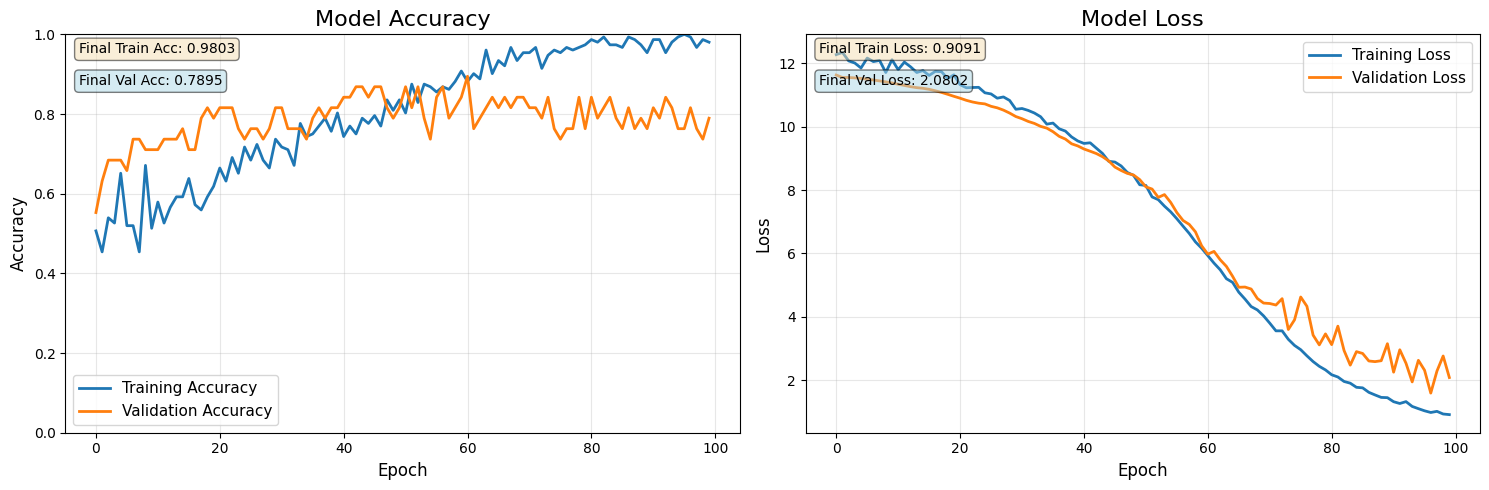

TRAINING SUMMARY
Total Epochs: 100
Best Training Accuracy: 1.0000
Best Validation Accuracy: 0.8947
Final Training Accuracy: 0.9803
Final Validation Accuracy: 0.7895
Final Training Loss: 0.9091
Final Validation Loss: 2.0802

⚠️  WARNING: Potential overfitting detected!
   Training-Validation accuracy gap: 0.1908


In [17]:
# Plot Training Accuracy and Loss
# Run this cell after training is complete to visualize the training metrics

import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics(history):
    """
    Plot training and validation accuracy and loss

    Args:
        history: Training history object returned by model.fit()
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Add accuracy values as text
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    ax1.text(0.02, 0.98, f'Final Train Acc: {final_train_acc:.4f}',
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax1.text(0.02, 0.90, f'Final Val Acc: {final_val_acc:.4f}',
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    # Add loss values as text
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    ax2.text(0.02, 0.98, f'Final Train Loss: {final_train_loss:.4f}',
             transform=ax2.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax2.text(0.02, 0.90, f'Final Val Loss: {final_val_loss:.4f}',
             transform=ax2.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("=" * 50)
    print("TRAINING SUMMARY")
    print("=" * 50)
    print(f"Total Epochs: {len(history.history['accuracy'])}")
    print(f"Best Training Accuracy: {max(history.history['accuracy']):.4f}")
    print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

    # Check for overfitting
    accuracy_gap = final_train_acc - final_val_acc
    if accuracy_gap > 0.1:
        print(f"\n⚠️  WARNING: Potential overfitting detected!")
        print(f"   Training-Validation accuracy gap: {accuracy_gap:.4f}")
    elif accuracy_gap < 0.05:
        print(f"\n✅ Good generalization - Training-Validation gap: {accuracy_gap:.4f}")
    else:
        print(f"\n📊 Moderate generalization - Training-Validation gap: {accuracy_gap:.4f}")

# Usage: Run this after training is complete
# Make sure 'history' variable is available from the training step
try:
    if 'history' in locals() or 'history' in globals():
        plot_training_metrics(history)
    else:
        print("❌ Error: 'history' variable not found!")
        print("Make sure to run the training cell first and that it completed successfully.")
        print("The training function should return a history object.")
except NameError:
    print("❌ Error: 'history' variable not found!")
    print("Make sure to run the training cell first and that it completed successfully.")
except Exception as e:
    print(f"❌ Error plotting training metrics: {e}")
    print("Make sure the training completed successfully and 'history' contains the training data.")


Generating Confusion Matrix and Computing Metrics...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
PERFORMANCE METRICS
Accuracy:     0.8158 (81.58%)
Precision:    0.8571 (85.71%)
Recall:       0.8182 (81.82%)
Sensitivity:  0.8182 (81.82%)
Specificity:  0.8125 (81.25%)
F1-Score:     0.8372 (83.72%)
Validation Loss: 1.5887

CONFUSION MATRIX BREAKDOWN:
True Negatives (TN):  13
False Positives (FP): 3
False Negatives (FN): 4
True Positives (TP):  18
Total Samples: 38


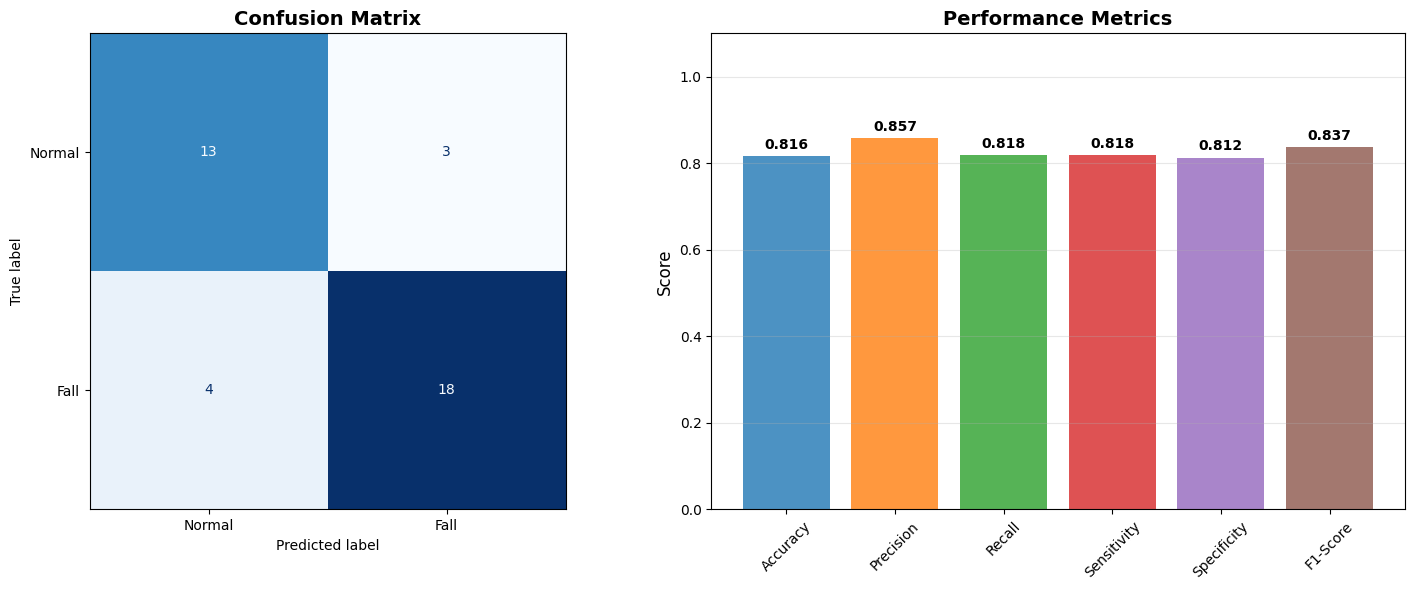


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.76      0.81      0.79        16
        Fall       0.86      0.82      0.84        22

    accuracy                           0.82        38
   macro avg       0.81      0.82      0.81        38
weighted avg       0.82      0.82      0.82        38


MODEL INSIGHTS:
✓ Excellent performance - High precision and recall
• The model correctly identifies 81.8% of fall cases (Sensitivity)
• The model correctly identifies 81.2% of normal cases (Specificity)
• When the model predicts a fall, it's correct 85.7% of the time
• Overall accuracy: 81.6%


In [18]:
# 10. Generate Confusion Matrix with Comprehensive Metrics
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                           accuracy_score, precision_score, recall_score,
                           f1_score, classification_report)
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have run the evaluation and have predictions and true labels
# If not, re-evaluate the model first
if 'model' in locals() and 'X_val' in locals() and 'y_val' in locals():
    print("\nGenerating Confusion Matrix and Computing Metrics...")

    # Get predictions from the model
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Calculate validation loss
    val_loss = model.evaluate(X_val, y_val, verbose=0)[0]

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1)  # Same as sensitivity
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1)

    # Calculate sensitivity and specificity manually for binary classification
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Same as recall
    specificity = tn / (tn + fp)

    # Display all metrics
    print("=" * 60)
    print("PERFORMANCE METRICS")
    print("=" * 60)
    print(f"Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision:    {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:       {recall:.4f} ({recall*100:.2f}%)")
    print(f"Sensitivity:  {sensitivity:.4f} ({sensitivity*100:.2f}%)")
    print(f"Specificity:  {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"F1-Score:     {f1:.4f} ({f1*100:.2f}%)")
    print(f"Validation Loss: {val_loss:.4f}")
    print("=" * 60)

    # Additional confusion matrix details
    print("\nCONFUSION MATRIX BREAKDOWN:")
    print(f"True Negatives (TN):  {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP):  {tp}")
    print(f"Total Samples: {tn + fp + fn + tp}")

    # Create a figure with subplots for better visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fall"])
    disp.plot(cmap=plt.cm.Blues, ax=ax1, colorbar=False)
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

    # Plot 2: Metrics Bar Chart
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'Sensitivity', 'Specificity', 'F1-Score']
    metrics_values = [accuracy, precision, recall, sensitivity, specificity, f1]

    bars = ax2.bar(metrics_names, metrics_values,
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'],
                   alpha=0.8)
    ax2.set_title('Performance Metrics', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_ylim(0, 1.1)
    ax2.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Rotate x-axis labels for better readability
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print detailed classification report
    print("\nDETAILED CLASSIFICATION REPORT:")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=["Normal", "Fall"]))

    # Additional insights
    print("\nMODEL INSIGHTS:")
    print("=" * 60)
    if precision > 0.8 and recall > 0.8:
        print("✓ Excellent performance - High precision and recall")
    elif precision > 0.7 and recall > 0.7:
        print("✓ Good performance - Acceptable precision and recall")
    else:
        print("⚠ Model may need improvement")

    print(f"• The model correctly identifies {sensitivity*100:.1f}% of fall cases (Sensitivity)")
    print(f"• The model correctly identifies {specificity*100:.1f}% of normal cases (Specificity)")
    print(f"• When the model predicts a fall, it's correct {precision*100:.1f}% of the time")
    print(f"• Overall accuracy: {accuracy*100:.1f}%")

else:
    print("Model or validation data not found. Please run the training and evaluation steps first.")
    print("Required variables: 'model', 'X_val', 'y_val'")

# Task
Apply the suggested improvements to the model and training process, including data augmentation, reduced model complexity, stronger regularization, learning rate reduction, and enhanced early stopping. Retrain the model and display the confusion matrix in a separate cell.

## Implement data augmentation

### Subtask:
Create functions to apply data augmentation techniques (noise, temporal jittering, scaling, mirroring) to the keypoint sequences.


**Reasoning**:
The subtask requires creating functions for data augmentation. I will define the functions for adding noise, temporal jitter, scaling, mirroring, and a combined augmentation function in a single code block.



In [19]:
def add_noise(sequence, noise_level=0.01):
    """Adds random noise to keypoint coordinates."""
    noise = np.random.normal(loc=0.0, scale=noise_level, size=sequence.shape)
    return sequence + noise

def temporal_jitter(sequence, jitter_range=2):
    """Randomly shifts keypoints within a small temporal window."""
    jittered_sequence = np.zeros_like(sequence)
    seq_len = sequence.shape[0]
    for i in range(seq_len):
        shift = random.randint(-jitter_range, jitter_range)
        source_frame = max(0, min(seq_len - 1, i + shift))
        jittered_sequence[i] = sequence[source_frame]
    return jittered_sequence

def scale_keypoints(sequence, scale_range=(0.9, 1.1)):
    """Randomly scales keypoint coordinates."""
    scale_factor = random.uniform(scale_range[0], scale_range[1])
    # Scale x and y coordinates, keep confidence as is
    scaled_sequence = sequence.copy()
    scaled_sequence[:, :, :2] *= scale_factor
    return scaled_sequence

def mirror_keypoints(sequence, mirror_indices, mirror_prob=0.5):
    """Randomly flips keypoints horizontally."""
    if random.random() < mirror_prob:
        mirrored_sequence = sequence.copy()
        # Assuming x-coordinates are the first column (index 0)
        # Flip x-coordinates around the center (e.g., 0.5 if normalized to [0, 1])
        # For raw coordinates, this might need adjustment based on image width
        # Let's assume normalized keypoints for now (range [0, 1])
        mirrored_sequence[:, :, 0] = 1.0 - mirrored_sequence[:, :, 0]

        # Swap left and right keypoints
        temp_sequence = mirrored_sequence.copy()
        for left_idx, right_idx in mirror_indices:
            mirrored_sequence[:, left_idx, :] = temp_sequence[:, right_idx, :]
            mirrored_sequence[:, right_idx, :] = temp_sequence[:, left_idx, :]

        return mirrored_sequence
    return sequence

def augment_sequence(sequence, mirror_indices, noise_level=0.01, jitter_range=2, scale_range=(0.9, 1.1), mirror_prob=0.5):
    """Applies a combination of data augmentation techniques."""
    augmented_sequence = sequence.copy()

    # Apply mirror augmentation
    augmented_sequence = mirror_keypoints(augmented_sequence, mirror_indices, mirror_prob)

    # Apply temporal jitter
    augmented_sequence = temporal_jitter(augmented_sequence, jitter_range)

    # Apply scaling
    augmented_sequence = scale_keypoints(augmented_sequence, scale_range)

    # Apply noise
    augmented_sequence = add_noise(augmented_sequence, noise_level)

    return augmented_sequence

# Define mirror indices for MoveNet keypoints (example - adjust based on actual keypoint mapping)
# MoveNet keypoint order: nose, left_eye, right_eye, left_ear, right_ear,
# left_shoulder, right_shoulder, left_elbow, right_elbow, left_wrist,
# right_wrist, left_hip, right_hip, left_knee, right_knee, left_ankle,
# right_ankle
# Mirror pairs: (1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)
movenet_mirror_indices = [
    (1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)
]

## Update data processing

### Subtask:
Modify the data processing function to incorporate the data augmentation during training.


**Reasoning**:
Modify the `process_dataset_with_smart_labeling` function to include data augmentation by applying the `augment_sequence` function to the extracted sequences before adding them to the dataset arrays.



In [20]:
def process_dataset_with_smart_labeling(video_files, labels, max_frames=30, val_size=0.2):
    """Process dataset using smart labeling and apply data augmentation."""
    X, y, video_names = [], [], []

    print("\nProcessing videos with smart labeling and applying augmentation...")
    for i, (video_path, label) in enumerate(tqdm(zip(video_files, labels), total=len(video_files))):
        try:
            sequence = extract_sequence_from_video(video_path, max_frames)
            if sequence is not None and sequence.shape[0] > 0:
                # Apply data augmentation to the sequence
                augmented_sequence = augment_sequence(sequence, movenet_mirror_indices)

                X.append(augmented_sequence)
                y.append(label)
                video_names.append(video_path)
            else:
                print(f"Skipping {video_path} due to sequence extraction failure or empty sequence.")
        except Exception as e:
            print(f"Error processing {video_path}: {e}")
            continue

    if len(X) == 0:
        print("No valid sequences found!")
        return None, None, None, None

    X = np.array(X)
    y = np.array(y)
    y_categorical = to_categorical(y, num_classes=2)

    fall_count = np.sum(y)
    normal_count = len(y) - fall_count

    print(f"\nFinal dataset:")
    print(f"Dataset shape: {X.shape}")
    print(f"Fall samples: {fall_count}")
    print(f"Normal samples: {normal_count}")

    # Split dataset - ONLY train/val split
    if len(np.unique(y)) > 1:  # Check if we have both classes
        try:
            # Stratified split
            X_train, X_val, y_train, y_val = train_test_split(
                X, y_categorical, test_size=val_size, stratify=y, random_state=42
            )
        except ValueError:
            # Fallback to random split
            X_train, X_val, y_train, y_val = train_test_split(
                X, y_categorical, test_size=val_size, random_state=42
            )
    else:
        # If only one class, do simple split
        X_train, X_val, y_train, y_val = train_test_split(
            X, y_categorical, test_size=val_size, random_state=42
        )

    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")

    return X_train, X_val, y_train, y_val


## Modify model architecture

### Subtask:
Adjust the `create_enhanced_model` function to reduce complexity, increase L2 regularization, and increase dropout rates as suggested.


**Reasoning**:
Adjust the create_enhanced_model function to reduce complexity, increase L2 regularization, and increase dropout rates as suggested.



In [21]:
# 8. Enhanced Model Architecture - Adjusted for reduced complexity, higher regularization, and dropout
def create_enhanced_model(n_steps, n_features, use_lr_schedule=False, use_normalization=False,
                         use_attention=True, use_class_weights=True):
    """Create enhanced CNN + BiLSTM + Self-Attention model with adjustments"""
    # Input layer: (batch_size, n_steps, n_features, 3) for (x,y,confidence)
    inputs = Input(shape=(n_steps, n_features, 3))

    # Optional normalization
    if use_normalization:
        x = Lambda(normalize_keypoints)(inputs)
    else:
        x = inputs

    # First CNN block with residual connection - Reduced filters
    residual = x
    x = TimeDistributed(Conv1D(filters=16, kernel_size=3, padding='same', # Reduced filters
                              activation="relu", kernel_regularizer=l2(0.01)))(x) # Increased L2
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv1D(filters=16, kernel_size=3, padding='same', # Reduced filters
                              activation="relu", kernel_regularizer=l2(0.01)))(x) # Increased L2
    x = TimeDistributed(BatchNormalization())(x)

    # Adjust residual connection if filter size changed
    if residual.shape[-1] != x.shape[-1]:
        # Use a 1x1 convolution to match dimensions for the residual connection
        residual = TimeDistributed(Conv1D(filters=16, kernel_size=1, padding='same',
                                          kernel_regularizer=l2(0.01)))(residual)

    x = Add()([x, residual]) # Residual connection

    x = TimeDistributed(MaxPooling1D(pool_size=2))(x)

    # Second CNN block - Reduced filters
    x = TimeDistributed(Conv1D(filters=32, kernel_size=3, padding='same', # Reduced filters
                              activation="relu", kernel_regularizer=l2(0.01)))(x) # Increased L2
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv1D(filters=32, kernel_size=3, padding='same', # Reduced filters
                              activation="relu", kernel_regularizer=l2(0.01)))(x) # Increased L2
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling1D(pool_size=2))(x)

    x = TimeDistributed(Flatten())(x)

    # First BiLSTM layer - Reduced units, increased regularization and dropout
    x = tf.keras.layers.Bidirectional(
        LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01), # Reduced units, Increased L2
             recurrent_regularizer=l2(0.01), dropout=0.5, recurrent_dropout=0.5), # Increased dropout
        merge_mode='concat')(x)

    # Enhanced Self-Attention for temporal modeling - Adjusted d_model
    if use_attention:
        attention_dim = 32*2  # BiLSTM output: 32*2 = 64
        x = TemporalSelfAttention(
            d_model=attention_dim,
            num_heads=8, # Keep or adjust heads based on d_model
            dropout_rate=0.5 # Increased dropout
        )(x)

        # Second BiLSTM layer - Reduced units, increased regularization and dropout
        x = tf.keras.layers.Bidirectional(
            LSTM(16, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), # Reduced units, Increased L2
                 dropout=0.5, recurrent_dropout=0.5), # Increased dropout
            merge_mode='concat')(x)
    else:
        # Without attention - Reduced units, increased regularization and dropout
        x = tf.keras.layers.Bidirectional(
            LSTM(16, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), # Reduced units, Increased L2
                 dropout=0.5, recurrent_dropout=0.5))(x) # Increased dropout


    # Dense layers - Reduced units, increased regularization and dropout
    x = Dense(32, activation="relu", kernel_regularizer=l2(0.01))(x) # Reduced units, Increased L2
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x) # Increased dropout

    # Output layer
    outputs = Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Optimizer
    if use_lr_schedule:
        # Adjust decay steps based on expected epochs or total steps
        lr_schedule = WarmUpCosineDecay(initial_lr=0.001, warmup_steps=500, decay_steps=5000) # Adjusted steps
        optimizer = Adam(learning_rate=lr_schedule, clipnorm=1.0) # Increased clipnorm
    else:
        optimizer = Adam(learning_rate=0.0005, clipnorm=1.0) # Reduced learning rate, increased clipnorm

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.Precision(name='precision')]
    )

    return model

## Modify training utilities

### Subtask:
Update the `create_training_callbacks` and `train_model` functions to use enhanced early stopping and potentially adjust the learning rate schedule.


**Reasoning**:
Update the create_training_callbacks function to increase patience and potentially adjust the learning rate schedule parameters in train_model for enhanced early stopping. Also ensure use_class_weights is explicitly set to True in train_model.



In [22]:
# 9. Training Utilities

# Note: Random seeds are already set in the previous cell

def get_class_weights(y_train):
    """Calculate class weights for balanced training"""
    class_indices = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(class_indices),
        y=class_indices
    )
    return dict(enumerate(class_weights))

def create_training_callbacks(use_lr_schedule=False):
    """Create training callbacks with enhanced early stopping"""
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=20,  # Increased patience for Early Stopping
            restore_best_weights=True,
            min_delta=0.0005 # Potentially adjust min_delta
        ),
        ModelCheckpoint(
            'best_fall_detection_model.keras',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

    if not use_lr_schedule:
        callbacks.append(
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10, # Increased patience for ReduceLROnPlateau
                min_lr=1e-7 # Potentially lower min_lr
            )
        )

    return callbacks

def train_model(x_train, y_train, x_val, y_val, n_steps, n_features,
                use_lr_schedule=True, use_normalization=False, use_attention=True,
                use_class_weights=True, batch_size=32, epochs=100):

    # Calculate decay steps based on dataset size and epochs
    # Assuming decay starts after warmup
    total_train_steps = (len(x_train) // batch_size) * epochs
    warmup_steps = int(total_train_steps * 0.1) # Example: 10% of total steps
    decay_steps = total_train_steps - warmup_steps


    model = create_enhanced_model(
        n_steps, n_features,
        use_lr_schedule=use_lr_schedule, # Ensure LR schedule is used if specified
        use_normalization=use_normalization,
        use_attention=use_attention,
        use_class_weights=use_class_weights # Pass class weights flag
    )

    print("Model Summary:")
    model.summary()

    # Ensure class weights are used
    class_weights = get_class_weights(y_train) if use_class_weights else None

    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=create_training_callbacks(use_lr_schedule),
        class_weight=class_weights,
        verbose=1
    )

    return model, history

# Note: plot_training_history and evaluate_model functions are already defined
# in the original notebook and don't need to be redefined here.
# Ensure the main execution block calls train_model with use_class_weights=True
# as already done in the latest version of the main execution block.

## Retrain the model

### Subtask:
Retrain the model using the updated data processing (with augmentation), modified model architecture (reduced complexity, stronger regularization, higher dropout), and enhanced training utilities (improved callbacks, potentially adjusted LR schedule).


**Reasoning**:
Execute the main execution block which calls the updated data processing and training functions to train the model with the applied improvements.



In [23]:
# Execute the main training process with the updated functions
if __name__ == "__main__":
    print("=" * 60)
    print("RE-TRAINING ENHANCED FALL DETECTION SYSTEM")
    print("=" * 60)

    # The dataset exploration and initial keypoint testing has already been done
    # in the previous execution of this block. Re-running it is redundant.
    # Assuming 'path' and 'video_files' are available from previous cells.

    # Smart labeling approach (re-run in case video_files were filtered or order changed)
    # This also helps confirm the distribution of labels after smart labeling.
    labels = smart_label_assignment(video_files)


    # Process dataset with smart labeling and augmentation
    print("\n" + "=" * 60)
    print("DATASET PROCESSING WITH SMART LABELING AND AUGMENTATION")
    print("=" * 60)

    X_train, X_val, y_train, y_val = process_dataset_with_smart_labeling(
        video_files, labels, max_frames=30, val_size=0.2
    )

    if X_train is None:
        print("ERROR: Dataset processing failed!")
        # Indicate failure but don't exit the notebook
    else:
        # Display final dataset info
        print(f"\n" + "=" * 40)
        print("FINAL DATASET INFORMATION (AFTER AUGMENTATION):")
        print(f"Train set: {X_train.shape}")
        print(f"Validation set: {X_val.shape}")
        print(f"Training labels: Fall={np.sum(np.argmax(y_train, axis=1))}, Normal={len(y_train)-np.sum(np.argmax(y_train, axis=1))}")
        print(f"Validation labels: Fall={np.sum(np.argmax(y_val, axis=1))}, Normal={len(y_val)-np.sum(np.argmax(y_val, axis=1))}")


        # Continue with model training using the updated model and utilities...
        print("\n" + "=" * 60)
        print("MODEL TRAINING (WITH UPDATED ARCHITECTURE AND UTILITIES)")
        print("=" * 60)

        try:
            model, history = train_model(
                X_train, y_train, X_val, y_val,
                n_steps=30,
                n_features=17,
                use_lr_schedule=True, # Use the updated LR schedule
                use_normalization=False, # Keep normalization off for now
                use_attention=True, # Keep attention layer
                use_class_weights=True, # Use class weights
                batch_size=16, # Adjusted batch size if needed
                epochs=100 # Set appropriate number of epochs
            )

            print("\nTraining completed successfully!")
            # Save the best model
            model.save('enhanced_fall_detection_model_retrained.keras') # Save with a new name
            print("Model saved as 'enhanced_fall_detection_model_retrained.keras'")


        except Exception as e:
            print(f"Training failed: {e}")
            import traceback
            traceback.print_exc()

    print("\nComplete!")

RE-TRAINING ENHANCED FALL DETECTION SYSTEM

SMART LABEL ASSIGNMENT
Analyzing video filename patterns...
Numeric range in filenames: 1 to 70
Keyword frequency in filenames:

Label assignment results:
Fall videos: 111
Normal videos: 79
Ratio: 58.4% falls, 41.6% normal

DATASET PROCESSING WITH SMART LABELING AND AUGMENTATION

Processing videos with smart labeling and applying augmentation...


100%|██████████| 190/190 [12:47<00:00,  4.04s/it]



Final dataset:
Dataset shape: (190, 30, 17, 3)
Fall samples: 111
Normal samples: 79
Train set: 152 samples
Validation set: 38 samples

FINAL DATASET INFORMATION (AFTER AUGMENTATION):
Train set: (152, 30, 17, 3)
Validation set: (38, 30, 17, 3)
Training labels: Fall=89, Normal=63
Validation labels: Fall=22, Normal=16

MODEL TRAINING (WITH UPDATED ARCHITECTURE AND UTILITIES)
Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30, 17, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, 30, 17,    │        160 │ input_layer_2[0]… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, 30, 17,    │         64 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, 30, 17,    │        784 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, 30, 17,    │         64 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_26 │ (None, 30, 17,    │         64 │ input_layer_2[0]… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 17,    │          0 │ time_distributed… │
│                     │ 16)               │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, 30, 8, 16) │          0 │ add[0][0]         │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, 30, 8, 32) │      1,568 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, 30, 8, 32) │        128 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, 30, 8, 32) │      3,104 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_31 │ (None, 30, 8, 32) │        128 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_32 │ (None, 30, 4, 32) │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_33 │ (None, 30, 128)   │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 30, 64)    │     41,216 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_self_atte… │ (None, 30, 64)    │     16,768 │ bidirectional_4[… │
│ (TemporalSelfAtten… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 32)        │     10,368 │ temporal_self_at

 Total params: 75,666 (295.57 KB)

 Trainable params: 75,410 (294.57 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5001 - loss: 7.6313 - precision: 0.5001 - recall: 0.5001
Epoch 1: val_accuracy improved from -inf to 0.44737, saving model to best_fall_detection_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.4965 - loss: 7.6347 - precision: 0.4965 - recall: 0.4965 - val_accuracy: 0.4474 - val_loss: 6.8958 - val_precision: 0.4474 - val_recall: 0.4474
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.4546 - loss: 7.7038 - precision: 0.4546 - recall: 0.4546
Epoch 2: val_accuracy did not improve from 0.44737
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.4563 - loss: 7.6953 - precision: 0.4563 - recall: 0.4563 - val_accuracy: 0.4211 - val_loss: 6.9075 - val_precision: 0.4211 - val_recall: 0.4211
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5067 - loss: 7.5097 - precision: 0.5067 - recall: 0.5067
Epoch 3: val_accuracy did not improve from 0.44737
10/10 ━━━━━━━━━━━━━━━━━━━━ 3

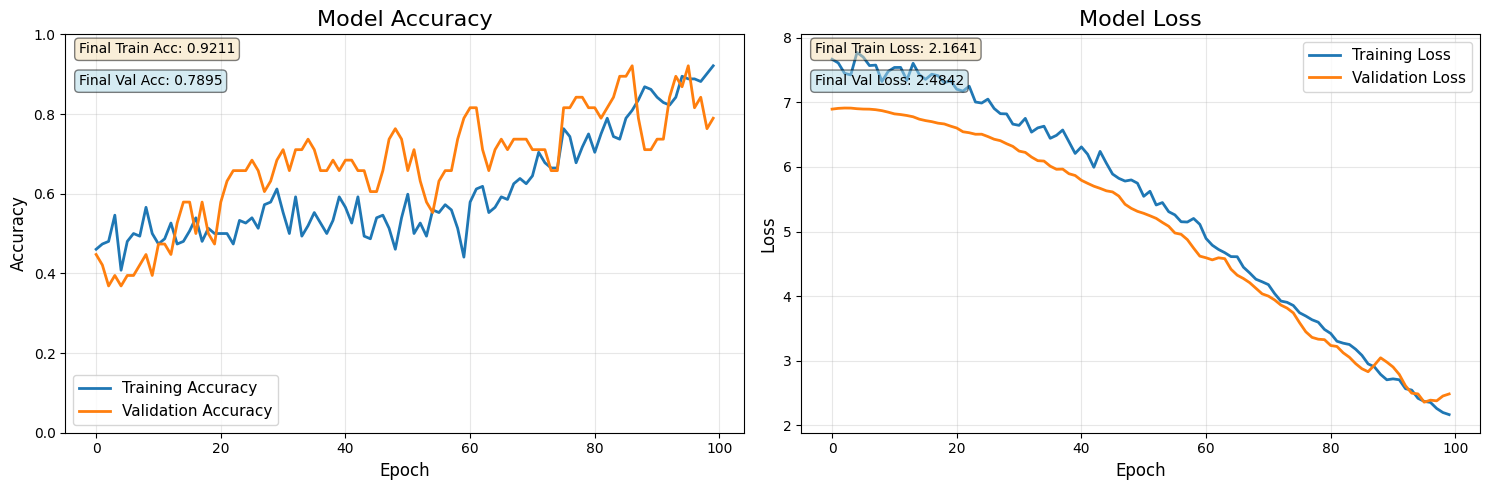

TRAINING SUMMARY
Total Epochs: 100
Best Training Accuracy: 0.9211
Best Validation Accuracy: 0.9211
Final Training Accuracy: 0.9211
Final Validation Accuracy: 0.7895
Final Training Loss: 2.1641
Final Validation Loss: 2.4842

⚠️  WARNING: Potential overfitting detected!
   Training-Validation accuracy gap: 0.1316


In [29]:
# Plot Training Accuracy and Loss
# Run this cell after training is complete to visualize the training metrics

import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics(history):
    """
    Plot training and validation accuracy and loss

    Args:
        history: Training history object returned by model.fit()
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Add accuracy values as text
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    ax1.text(0.02, 0.98, f'Final Train Acc: {final_train_acc:.4f}',
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax1.text(0.02, 0.90, f'Final Val Acc: {final_val_acc:.4f}',
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    # Add loss values as text
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    ax2.text(0.02, 0.98, f'Final Train Loss: {final_train_loss:.4f}',
             transform=ax2.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax2.text(0.02, 0.90, f'Final Val Loss: {final_val_loss:.4f}',
             transform=ax2.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("=" * 50)
    print("TRAINING SUMMARY")
    print("=" * 50)
    print(f"Total Epochs: {len(history.history['accuracy'])}")
    print(f"Best Training Accuracy: {max(history.history['accuracy']):.4f}")
    print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

    # Check for overfitting
    accuracy_gap = final_train_acc - final_val_acc
    if accuracy_gap > 0.1:
        print(f"\n⚠️  WARNING: Potential overfitting detected!")
        print(f"   Training-Validation accuracy gap: {accuracy_gap:.4f}")
    elif accuracy_gap < 0.05:
        print(f"\n✅ Good generalization - Training-Validation gap: {accuracy_gap:.4f}")
    else:
        print(f"\n📊 Moderate generalization - Training-Validation gap: {accuracy_gap:.4f}")

# Usage: Run this after training is complete
# Make sure 'history' variable is available from the training step
try:
    if 'history' in locals() or 'history' in globals():
        plot_training_metrics(history)
    else:
        print("❌ Error: 'history' variable not found!")
        print("Make sure to run the training cell first and that it completed successfully.")
        print("The training function should return a history object.")
except NameError:
    print("❌ Error: 'history' variable not found!")
    print("Make sure to run the training cell first and that it completed successfully.")
except Exception as e:
    print(f"❌ Error plotting training metrics: {e}")
    print("Make sure the training completed successfully and 'history' contains the training data.")


Generating Confusion Matrix and Computing Metrics...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
PERFORMANCE METRICS
Accuracy:     0.9211 (92.11%)
Precision:    0.8800 (88.00%)
Recall:       1.0000 (100.00%)
Sensitivity:  1.0000 (100.00%)
Specificity:  0.8125 (81.25%)
F1-Score:     0.9362 (93.62%)
Validation Loss: 2.3566

CONFUSION MATRIX BREAKDOWN:
True Negatives (TN):  13
False Positives (FP): 3
False Negatives (FN): 0
True Positives (TP):  22
Total Samples: 38


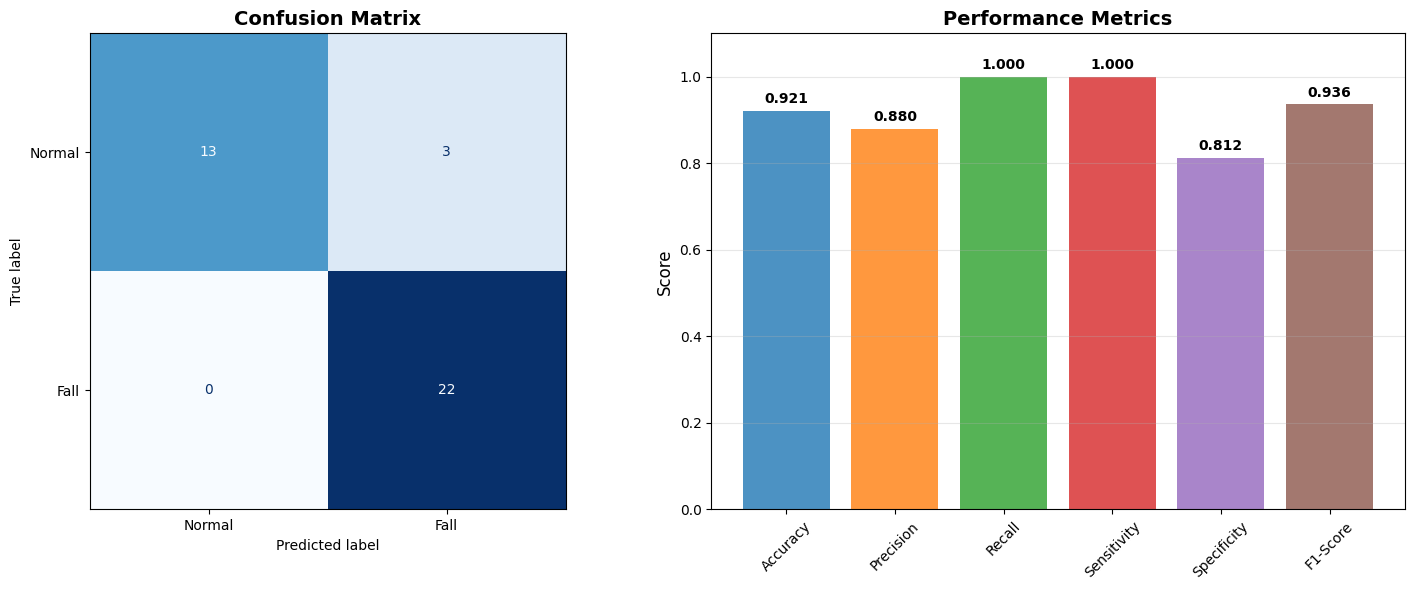


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       1.00      0.81      0.90        16
        Fall       0.88      1.00      0.94        22

    accuracy                           0.92        38
   macro avg       0.94      0.91      0.92        38
weighted avg       0.93      0.92      0.92        38


MODEL INSIGHTS:
✓ Excellent performance - High precision and recall
• The model correctly identifies 100.0% of fall cases (Sensitivity)
• The model correctly identifies 81.2% of normal cases (Specificity)
• When the model predicts a fall, it's correct 88.0% of the time
• Overall accuracy: 92.1%


In [28]:
# 10. Generate Confusion Matrix with Comprehensive Metrics
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                           accuracy_score, precision_score, recall_score,
                           f1_score, classification_report)
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have run the evaluation and have predictions and true labels
# If not, re-evaluate the model first
if 'model' in locals() and 'X_val' in locals() and 'y_val' in locals():
    print("\nGenerating Confusion Matrix and Computing Metrics...")

    # Get predictions from the model
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Calculate validation loss
    val_loss = model.evaluate(X_val, y_val, verbose=0)[0]

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1)  # Same as sensitivity
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1)

    # Calculate sensitivity and specificity manually for binary classification
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Same as recall
    specificity = tn / (tn + fp)

    # Display all metrics
    print("=" * 60)
    print("PERFORMANCE METRICS")
    print("=" * 60)
    print(f"Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision:    {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:       {recall:.4f} ({recall*100:.2f}%)")
    print(f"Sensitivity:  {sensitivity:.4f} ({sensitivity*100:.2f}%)")
    print(f"Specificity:  {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"F1-Score:     {f1:.4f} ({f1*100:.2f}%)")
    print(f"Validation Loss: {val_loss:.4f}")
    print("=" * 60)

    # Additional confusion matrix details
    print("\nCONFUSION MATRIX BREAKDOWN:")
    print(f"True Negatives (TN):  {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP):  {tp}")
    print(f"Total Samples: {tn + fp + fn + tp}")

    # Create a figure with subplots for better visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fall"])
    disp.plot(cmap=plt.cm.Blues, ax=ax1, colorbar=False)
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

    # Plot 2: Metrics Bar Chart
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'Sensitivity', 'Specificity', 'F1-Score']
    metrics_values = [accuracy, precision, recall, sensitivity, specificity, f1]

    bars = ax2.bar(metrics_names, metrics_values,
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'],
                   alpha=0.8)
    ax2.set_title('Performance Metrics', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_ylim(0, 1.1)
    ax2.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Rotate x-axis labels for better readability
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print detailed classification report
    print("\nDETAILED CLASSIFICATION REPORT:")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=["Normal", "Fall"]))

    # Additional insights
    print("\nMODEL INSIGHTS:")
    print("=" * 60)
    if precision > 0.8 and recall > 0.8:
        print("✓ Excellent performance - High precision and recall")
    elif precision > 0.7 and recall > 0.7:
        print("✓ Good performance - Acceptable precision and recall")
    else:
        print("⚠ Model may need improvement")

    print(f"• The model correctly identifies {sensitivity*100:.1f}% of fall cases (Sensitivity)")
    print(f"• The model correctly identifies {specificity*100:.1f}% of normal cases (Specificity)")
    print(f"• When the model predicts a fall, it's correct {precision*100:.1f}% of the time")
    print(f"• Overall accuracy: {accuracy*100:.1f}%")

else:
    print("Model or validation data not found. Please run the training and evaluation steps first.")
    print("Required variables: 'model', 'X_val', 'y_val'")